# ACME: Conditioning and Stability
## Jincheng(Eric) Huang

1. Write a function that accepts a matrix $A$ and computes its condition number using (10.3). Use `scipy.linalg.svd()` or `scipy.linalg.svdals()` to compute the singular values of $A$. Avoid computing $A^{-1}$. If the smallest singular value is 0, return $\infty$.
    Validate your function by comparing it to `np.linalg.cond()`. Check that orthonormal matrices have a condition number of 1 (use `scipy.linalg.qr()` to generate an orthonormal matrix) and that singular matrices have a condition number of $\infty$ according to your function.

In [1]:
import numpy as np
import sympy as sy
from scipy.linalg import svd,qr,norm,eig,inv,solve_triangular
from matplotlib import pyplot as plt

In [2]:
def condition_number(A):
    # Find the singular values
    _,sing_val,_ = svd(A)
    sing_max = max(sing_val)
    sing_min = min(sing_val)
    
    cond = sing_max/sing_min if sing_min != 0 else np.inf
    return cond

In [3]:
A = np.random.rand(3,3)
q,r = qr(A)
c = condition_number(q)
print(c)

1.0000000000000004


2. Write a function that carries out the following experiment 100 times.

    1)  Randomly perturb the true coefficients of the Wilkinson polynomial by replacing each coefficient $c_i$ with $c_i * r_i$, where $r_i$ is drawn from a normal distribution centered at 1 with standard deviation $10^{-10}$ (use `np.random.normal()`).
    
    2) Plot the perturbed roots as small points in the complex plane. That is, plot the real part of the coefficients on the x-axis and the imaginary part on the y-axis. Plot on the same figure in each experiment.
    
    3) Compute the absolute and relative condition numbers with the $L^{\infty}$ norm.
    
    Plot the roots of the unperturbed Wilkinson polynomial with the perturbed roots. Finally, return the average computed absolute and relative condition numbers.

In [4]:
# The roots of w are 1, 2, ..., 20.
w_roots = np.arange(1,21)

# Get the exact Wilkinson polynomial coefficients using SymPy.
x, i = sy.symbols('x i')
w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
w_coeffs = np.array(w.all_coeffs())

In [5]:
def random_perturb_Wilkinson(w_coeffs):
    n = len(w_coeffs)
    w_roots = np.arange(1,n)
    k,kr = np.zeros(100,),np.zeros(100,)
    for i in range(100):
        # Generate perturbations of the coefficients
        r = np.random.normal(1,1e-10,(n,))
        new_coeffs = w_coeffs * r
        h = w_coeffs - new_coeffs
        
        # Calculate roots of the new polynomials
        new_roots = np.roots(np.poly1d(new_coeffs))
        roots_re,roots_im = new_roots.real, new_roots.imag
        
        # Calculate absolute and relative condition numbers
        new_roots,w_roots = np.sort(new_roots),np.sort(w_roots)
        k[i] = norm(new_roots-w_roots,np.inf) / norm(h,np.inf)
        kr[i] = k[i] * norm(w_coeffs,np.inf) / norm(w_roots,np.inf)
        
        # Plot the roots
        if i == 0:
            plt.plot(roots_re,roots_im,'k,',label='Perturbed')
        else:
            plt.plot(roots_re,roots_im,'k,')
        
    orig_roots = np.roots(np.poly1d(w_coeffs))
    plt.plot(orig_roots,np.zeros_like(orig_roots),'b.',label='Original')
    plt.xlabel('Real Axis')
    plt.ylabel('Imaginary Axis')
    plt.legend()
    plt.show()
    
    # Calculate the average absolute and relative condition numbers
    k_mean,kr_mean = np.mean(k),np.mean(kr)
    return k_mean,kr_mean

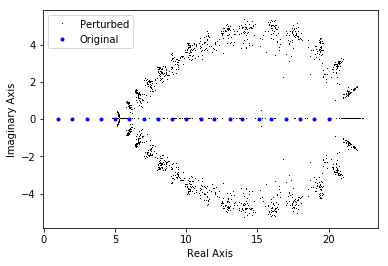

Average absolute condition number: 0.00000
Average relative condition number: 2581254554.94920


In [6]:
k_mean,kr_mean = random_perturb_Wilkinson(w_coeffs)
print('Average absolute condition number: %1.5f' % k_mean)
print('Average relative condition number: %1.5f' % kr_mean)

3. Write a function that accepts a matrix $A$ and estimates the condition number of the eigenvalue problem using (10.4). For the perturbation $H$, construct a matrix with complex entries where the real and imaginary parts are drawn from normal distributions centered at 0 with standard deviation $\sigma = 10^{-10}$.

In [7]:
def condition_number_complex(A):
    eigen_val,_ = eig(A)
    H_re = np.random.normal(0,1e-10,A.shape)
    H_im = np.random.normal(0,1e-10,A.shape)
    H = H_re + H_im*1j
    A_pert = A + H
    eigen_val_pert,_ = eig(A_pert)
    
    k = norm(eigen_val-eigen_val_pert,2) / norm(H,2)
    kr = norm(A,2)/norm(eigen_val,2) * k
    return k,kr

In [8]:
A = np.random.rand(3,3)
A = np.ones((3,3))
k,kr = condition_number_complex(A)
print('Absolute condition number: %1.5f' % k)
print('Relative condition number: %1.5f' % kr)

Absolute condition number: 0.69088
Relative condition number: 0.69088


4. Write a function that accepts bounds $[x_{min}, x_{max}, y_{min}, y_{max}]$ and an integer res. Use your function from Problem 3 to compute the relative condition number of the eigenvalue problem for the $2\times 2$ matrix
    $$
    \left[\begin{array}{ll}{1} & {x} \\ {y} & {1}\end{array}\right]
    $$
    at every point of an evenly spaced $res\times res$ grid over the domain $\left[x_{\min }, x_{\max }\right] \times\left[y_{\min }, y_{\max }\right]$. Plot these estimated relative condition numbers using `plt.pcolormesh()` and the colormap `cmap='gray_r'`.

In [9]:
def plot_relative_cond(xmin,xmax,ymin,ymax):
    res = 200
    x_grid = np.linspace(xmin,xmax,res)
    y_grid = np.linspace(ymin,ymax,res)
    kr = np.zeros((res,res))
    for ix,x in enumerate(x_grid):
        for iy,y in enumerate(y_grid):
            A = np.array([[1,x],[y,1]])
            _,kr[ix,iy] = condition_number_complex(A)
    
    plt.pcolormesh(kr,cmap='gray_r')
    plt.colorbar()

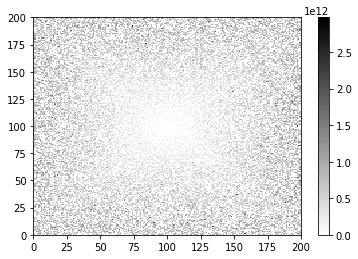

In [10]:
xmin,xmax = -100,100
ymin,ymax = -100,100
plot_relative_cond(xmin,xmax,ymin,ymax)

5. Write a function that accepts an integer $n$. Solve for the coefficients of the polynomial of degree $n$ that best fits the data found in `stability_data.npy`. Use two approaches to get the least squares solution:
    
    1) Use `la.inv()` to solve the normal equations: $\mathbf{x}=\left(A^{\top} A\right)^{-1} A^{\top} \mathbf{b}$. Although this approach seems intuitive, it is actually highly unstable and can return an answer with a very large forward error.
    
    2) Use `la.qr()` with mode='economic' and `la.solve_triangular()` to solve the system $R x=Q^{\top} b$, which is equivalent to solving the normal equations. This algorithm has the advantage of being stable.
    
    Plot the resulting polynomials together with the raw data points. Return the forward error $\|A \mathbf{x}-\mathbf{b}\|_{2}$ of both approximations.
    Test your function using various values of $n$, taking special note of what happens for values of $n$ near $14$.

In [11]:
def stability_polynomial(n,x,y):
    X = np.vander(x, n+1)
    β1 = inv(X.T.dot(X)).dot(X.T.dot(y))
    q,r = qr(X,mode='economic')
    β2 = solve_triangular(r,q.T.dot(y))
        
    forward_error1 = norm(X.dot(β1)-y)
    forward_error2 = norm(X.dot(β2)-y)
    
    y1 = np.polyval(β1,x)
    y2 = np.polyval(β2,x)
    plt.plot(x,y,'k.')
    plt.plot(x,y1,label='Normal Equations')
    plt.plot(x,y2,label='QR Solver')
    plt.legend()
    

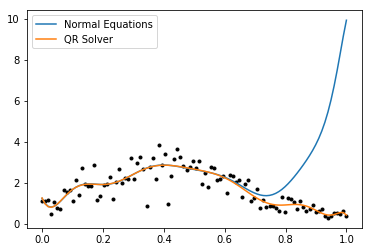

In [12]:
# Load the data and set up the matrix
xk, yk = np.load("stability_data.npy").T
n = 12
stability_polynomial(n,xk,yk)

6. Let $I(n)=\int_{0}^{1} x^{n} e^{x-1} d x$. It can be shown that for a positive integer $n$,
$$
I(n)=(-1)^{n} ! n+(-1)^{n+1} \frac{n !}{e}
$$
where $! n=n ! \sum_{k=0}^{n} \frac{(-1)^{k}}{k !}$ is the _subfactorial_ of $n$. Write a function to do the following:

    1) Use SymPy’s `sy.integrate()` to evaluate the integral form of $I(n)$ for $n=5,10,...,50$. Convert the symbolic results of each integration to a float. Since this is done symbolically, these values can be accepted as the true values of $I(n)$.
    
    2) Use the equation above to compute $I(n)$ for the same values of $n$. Use `sy.subfactorial()` to compute $!n$ and `sy.factorial()` to compute $n!$.
    
    3) Plot the relative forward error of the results computed in step 2 at each of the given values of $n$. Use a log scale on the y-axis. Is (10.6) a stable way to compute $I(n)$? Why?

In [13]:
# Generate symbolic function I(n) using the first equation
x,n = sy.symbols('x n')
f1 = (x)**n * sy.functions.elementary.exponential.exp(x) * np.exp(-1)
In_1 = sy.integrate(f1,(x,0,1))

# Generate symbolic function I(n) using the second equation
In_2 = (-1)**n * sy.subfactorial(n) + (-1)**(n+1) * sy.factorial(n) / np.exp(1)

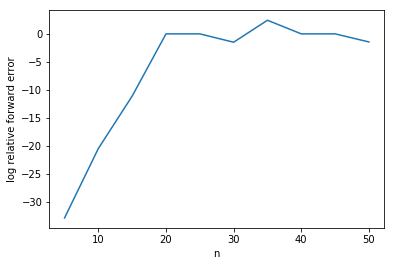

In [14]:
# Calculate the relative forward error for the factorial method
n_list = 5*np.arange(1,11,1)
relative_forward_error = np.zeros(10,)
for i,n_curr in enumerate(n_list):
    f_true = sy.N(In_1.subs(n,n_curr))
    f_true = np.array([f_true],dtype='float')
    f_subfactorial = sy.N(In_2.subs(n,n_curr))
    f_subfactorial = np.array([f_subfactorial],dtype='float')
    relative_forward_error[i] = np.log(norm(f_true-f_subfactorial)/norm(f_true))

# Plot the results
plt.plot(n_list,relative_forward_error)
plt.xlabel('n')
plt.ylabel('log relative forward error')
plt.show()